In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cirq

In [5]:
def make_quantum_teleportation_circuit(gate):
    """Returns a circuit for quantum teleportation.

    This circuit 'teleports' a random qubit state prepared by
    the input gate from Alice to Bob.
    """
    circuit = cirq.Circuit()

    # Get the three qubits involved in the teleportation protocol.
    msg = cirq.NamedQubit("Message")
    alice = cirq.NamedQubit("Alice")
    bob = cirq.NamedQubit("Bob")

    # The input gate prepares the message to send.
    circuit.append(gate(msg))

    # Create a Bell state shared between Alice and Bob.
    circuit.append([cirq.H(alice), cirq.CNOT(alice, bob)])

    # Bell measurement of the Message and Alice's entangled qubit.
    circuit.append([cirq.CNOT(msg, alice), cirq.H(msg), cirq.measure(msg, alice)])

    # Uses the two classical bits from the Bell measurement to recover the
    # original quantum message on Bob's entangled qubit.
    circuit.append([cirq.CNOT(alice, bob), cirq.CZ(msg, bob)])

    return circuit

In [6]:
"""Visualize the teleportation circuit."""
# Gate to put the message qubit in some state to send.
gate = cirq.X ** 0.25

# Create the teleportation circuit.
circuit = make_quantum_teleportation_circuit(gate)
print("Teleportation circuit:\n")
print(circuit)

Teleportation circuit:

Alice: ─────H────────@───X───────M───@───────
                     │   │       │   │
Bob: ────────────────X───┼───────┼───X───@───
                         │       │       │
Message: ───X^0.25───────@───H───M───────@───


In [7]:
"""Display the Bloch vector of the message qubit."""
message = cirq.Circuit(gate.on(cirq.NamedQubit("Message"))).final_state_vector()
message_bloch_vector = cirq.bloch_vector_from_state_vector(message, index=0)
print("Bloch vector of message qubit:")
print(np.round(message_bloch_vector, 3))

Bloch vector of message qubit:
[-0.    -0.707  0.707]


In [8]:
def make_qft(qubits):
    """Generator for the QFT on a list of qubits."""
    qreg = list(qubits)
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (1 / 2 ** (i + 1)))(qubit, q_head)

In [9]:
"""Visually check the QFT circuit."""
qubits = cirq.LineQubit.range(4)
qft = cirq.Circuit(make_qft(qubits))
print(qft)

                  ┌───────┐   ┌────────────┐   ┌───────┐
0: ───H───@────────@───────────@───────────────────────────────────────
          │        │           │
1: ───────@^0.5────┼─────H─────┼──────@─────────@──────────────────────
                   │           │      │         │
2: ────────────────@^0.25──────┼──────@^0.5─────┼─────H────@───────────
                               │                │          │
3: ────────────────────────────@^(1/8)──────────@^0.25─────@^0.5───H───
                  └───────┘   └────────────┘   └───────┘


In [10]:
"""Use the built-in QFT in Cirq."""
qft_operation = cirq.qft(*qubits, without_reverse=True)
qft_cirq = cirq.Circuit(qft_operation)
print(qft_cirq)

0: ───qft[norev]───
      │
1: ───#2───────────
      │
2: ───#3───────────
      │
3: ───#4───────────


In [11]:
"""Check equality of the 'manual' and 'built-in' QFTs."""
np.testing.assert_allclose(cirq.unitary(qft), cirq.unitary(qft_cirq))

In [12]:
def make_qft_inverse(qubits):
    """Generator for the inverse QFT on a list of qubits."""
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

In [13]:
"""Visually check the inverse QFT circuit."""
qubits = cirq.LineQubit.range(4)
iqft = cirq.Circuit(make_qft_inverse(qubits))
print(iqft)

                   ┌────────┐   ┌──────────────┐   ┌────────┐
0: ──────────────────────────────@──────────────────@───────────@────────H───
                                 │                  │           │
1: ─────────────────@────────────┼───────@──────────┼──────H────@^-0.5───────
                    │            │       │          │
2: ───────@─────────┼──────H─────┼───────@^-0.5─────@^-0.25──────────────────
          │         │            │
3: ───H───@^-0.5────@^-0.25──────@^(-1/8)────────────────────────────────────
                   └────────┘   └──────────────┘   └────────┘


In [14]:
"""Use the built-in inverse QFT in Cirq."""
iqft_operation = cirq.qft(*qubits, inverse=True, without_reverse=True)
iqft_cirq = cirq.Circuit(iqft_operation)
print(iqft_cirq)

0: ───qft[norev]^-1───
      │
1: ───#2──────────────
      │
2: ───#3──────────────
      │
3: ───#4──────────────


In [15]:
"""Set up the unitary and number of bits to use in phase estimation."""
# Value of θ which appears in the definition of the unitary U above.
# Try different values.
theta = 0.234

# Define the unitary U.
U = cirq.Z ** (2 * theta)

# Accuracy of the estimate for theta. Try different values.
n_bits = 3

In [16]:
"""Build the first part of the circuit for phase estimation."""
# Get qubits for the phase estimation circuit.
qubits = cirq.LineQubit.range(n_bits)
u_bit = cirq.NamedQubit('u')

# Build the first part of the phase estimation circuit.
phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

for i, bit in enumerate(qubits):
    phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - i - 1)))

print(phase_estimator)

0: ───H───@──────────────────────────────
          │
1: ───H───┼──────────@───────────────────
          │          │
2: ───H───┼──────────┼─────────@─────────
          │          │         │
u: ───────Z^-0.128───Z^0.936───Z^0.468───


In [17]:
"""Build the last part of the circuit (inverse QFT) for phase estimation."""
# Do the inverse QFT.
phase_estimator.append(make_qft_inverse(qubits[::-1]))

# Add measurements to the end of the circuit
phase_estimator.append(cirq.measure(*qubits, key='m'))
print(phase_estimator)

                                         ┌────────┐
0: ───H───@──────────H─────────@──────────@────────────────────────M('m')───
          │                    │          │                        │
1: ───H───┼──────────@─────────@^-0.5─────┼──────H────@────────────M────────
          │          │                    │           │            │
2: ───H───┼──────────┼─────────@──────────@^-0.25─────@^-0.5───H───M────────
          │          │         │
u: ───────Z^-0.128───Z^0.936───Z^0.468──────────────────────────────────────
                                         └────────┘


In [18]:
"""Set the input state of the eigenvalue register."""
# Add gate to change initial state to |1>.
phase_estimator.insert(0, cirq.X(u_bit))

print(phase_estimator)

                                         ┌────────┐
0: ───H───@──────────H─────────@──────────@────────────────────────M('m')───
          │                    │          │                        │
1: ───H───┼──────────@─────────@^-0.5─────┼──────H────@────────────M────────
          │          │                    │           │            │
2: ───H───┼──────────┼─────────@──────────@^-0.25─────@^-0.5───H───M────────
          │          │         │
u: ───X───Z^-0.128───Z^0.936───Z^0.468──────────────────────────────────────
                                         └────────┘


In [19]:
"""Simulate the circuit and convert from measured bit values to estimated θ values."""
# Simulate the circuit.
sim = cirq.Simulator()
result = sim.run(phase_estimator, repetitions=10)

# Convert from output bitstrings to estimate θ values.
theta_estimates = np.sum(2 ** np.arange(n_bits) * result.measurements['m'], axis=1) / 2**n_bits
print(theta_estimates)

[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


In [21]:
def phase_estimation(theta, n_bits, n_reps=10, prepare_eigenstate_gate=cirq.X):
    # Define qubit registers.
    qubits = cirq.LineQubit.range(n_bits)
    u_bit = cirq.NamedQubit('u')

    # Define the unitary U.
    U = cirq.Z ** (2 * theta)

    # Start with Hadamards on every qubit.
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))

    # Do the controlled powers of the unitary U.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n_bits - 1 - i)))

    # Do the inverse QFT.
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Add measurements.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Gate to choose the initial state for the u_bit. Placing X here chooses the |1> state.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # Code to simulate measurements
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=n_reps)

    # Convert measurements into estimates of theta
    theta_estimates = np.sum(2**np.arange(n_bits)*result.measurements['m'], axis=1)/2**n_bits

    return theta_estimates

In [22]:
"""Analyze convergence vs n_bits."""
# Set the value of theta. Try different values.
theta = 0.123456

max_nvals = 16
nvals = np.arange(1, max_nvals, step=1)

# Get the estimates at each value of n.
estimates = []
for n in nvals:
    estimate = phase_estimation(theta=theta, n_bits=n, n_reps=1)[0]
    estimates.append(estimate)

C:\Users\Joker\AppData\Local\Temp/ipykernel_13536/4057201709.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


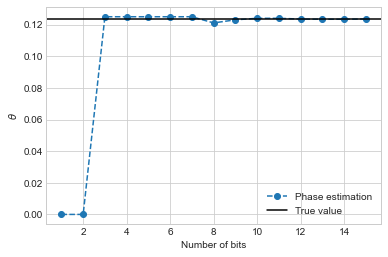

In [24]:
"""Plot the results."""
plt.style.use("seaborn-whitegrid")

plt.plot(nvals, estimates, "--o", label="Phase estimation")
plt.axhline(theta, label="True value", color="black")

plt.legend()
plt.xlabel("Number of bits")
plt.ylabel(r"$\theta$");

In [25]:
"""Run phase estimation without starting in an eigenstate."""
# Value of theta.
theta = 0.123456

# Number of qubits.
n = 4

# Run phase estimation starting in the state H|0⟩ = |+⟩.
res = phase_estimation(theta=theta, n_bits=n, n_reps=10, prepare_eigenstate_gate=cirq.H)
print(res)

[0.    0.125 0.125 0.    0.    0.125 0.125 0.    0.125 0.   ]


In [26]:
"""Get qubits to use in the circuit for Grover's algorithm."""
# Number of qubits n.
nqubits = 2

# Get qubit registers.
qubits = cirq.LineQubit.range(nqubits)
ancilla = cirq.NamedQubit("Ancilla")

In [27]:
def make_oracle(qubits, ancilla, xprime):
    """Implements the function {f(x) = 1 if x == x', f(x) = 0 if x != x'}."""
    # For x' = (1, 1), the oracle is just a Toffoli gate.
    # For a general x', we negate the zero bits and implement a Toffoli.

    # Negate zero bits, if necessary.
    yield (cirq.X(q) for (q, bit) in zip(qubits, xprime) if not bit)

    # Do the Toffoli.
    yield (cirq.TOFFOLI(qubits[0], qubits[1], ancilla))

    # Negate zero bits, if necessary.
    yield (cirq.X(q) for (q, bit) in zip(qubits, xprime) if not bit)

In [28]:
def grover_iteration(qubits, ancilla, oracle):
    """Performs one round of the Grover iteration."""
    circuit = cirq.Circuit()

    # Create an equal superposition over input qubits.
    circuit.append(cirq.H.on_each(*qubits))

    # Put the output qubit in the |-⟩ state.
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])

    # Query the oracle.
    circuit.append(oracle)

    # Construct Grover operator.
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on(qubits[1]))
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    circuit.append(cirq.H.on(qubits[1]))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))

    # Measure the input register.
    circuit.append(cirq.measure(*qubits, key="result"))

    return circuit

In [29]:
"""Select a 'marked' bitstring x' at random."""
xprime = [random.randint(0, 1) for _ in range(nqubits)]
print(f"Marked bitstring: {xprime}")

Marked bitstring: [1, 0]


In [30]:
"""Create the circuit for Grover's algorithm."""
# Make oracle (black box)
oracle = make_oracle(qubits, ancilla, xprime)

# Embed the oracle into a quantum circuit implementing Grover's algorithm.
circuit = grover_iteration(qubits, ancilla, oracle)
print("Circuit for Grover's algorithm:")
print(circuit)

Circuit for Grover's algorithm:
0: ─────────H───────@───H───X───────────@───X───H───────M('result')───
                    │                   │               │
1: ─────────H───X───@───X───H───X───H───X───H───X───H───M─────────────
                    │
Ancilla: ───X───H───X─────────────────────────────────────────────────


In [31]:
"""Simulate the circuit for Grover's algorithm and check the output."""
# Helper function.
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

# Sample from the circuit a couple times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)

# Look at the sampled bitstrings.
frequencies = result.histogram(key="result", fold_func=bitstring)
print('Sampled results:\n{}'.format(frequencies))

# Check if we actually found the secret value.
most_common_bitstring = frequencies.most_common(1)[0][0]
print("\nMost common bitstring: {}".format(most_common_bitstring))
print("Found a match? {}".format(most_common_bitstring == bitstring(xprime)))

Sampled results:
Counter({'10': 10})

Most common bitstring: 10
Found a match? True
